# Setup

 Import standard modules

In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Find project root, append to path, and define wdir for data

In [2]:
from pyprojroot import here

root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim"

Import project modules from src folder

In [3]:
from src import features, models
from src import visualization as viz

## Load tides

Sutarkhali pressure data from 2019 collected by Rip Hale and Rachel Bain. Original data was sampled every 10 min. Data was cleaned, processed, and upscaled to 1 s using the OCE package (https://cran.r-project.org/web/packages/oce/) in R. Processed data is stored in `data/interim/` in the feather format.

`tides.feather` is 1 yr of data sampled every 1 s

`tides-debug.feather` is 1 inundation cycle sampled every 1 s

In [4]:
tides = features.load_tide(wdir, "tides.feather")

Downsample tide data

In [8]:
dt = 1  # seconds
tides = tides.iloc[0:-1:dt]

## Set model parameters

In [9]:
# Set grain parameters and settling velocity
grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650  # grain density (kg/m^3)
settle_rate = models.stokes_settling(
    grain_dia=grain_dia, grain_den=grain_den
)  # settling rate determined by Stokes' Law

# Set basic model parameters
bound_conc = 0.8  # boundary concentration (g/L or kg/m^3)
bulk_dens = 1100  # dry bulk density of sediment (kg/m^3)
min_depth = 0.001  # Minimum depth required before integrating. Used for stability at very shallow depths. (m)
init_elev = 1.25  # initial elevation (m)
years = 1  # total run length (yr)
slr = 0.005  # yearly rate of sea level rise (m)

# Run model

Run model for specified number of years and returns a `pandas.Series` for the tides and a `ResultClass` for the ODE solutions.

`model_tides`: Tide series at the given timestep for the full length of the run with any sea level rise superimposed.

`model_results`: Results modeled after `scipy.integrate.solve_ivp` results for conistency
- `model_results.t`: numpy.ndarray of times (s)
- `model_result.y`: list of ODE solutions for concentration and elevation
  - `model_results.y[0]`: numpy.ndarray of concentrations (g/L)
  - `model_results.y[1]`: numpy.ndarray of elevations (m)

In [10]:
model_tides, model_results = models.run_model(
    tides_ts=tides,
    settle_rate=settle_rate,
    bulk_dens=bulk_dens,
    bound_conc=bound_conc,
    init_elev=init_elev,
    years=years,
    slr=slr,
    verbose=True,
)

Simulation length:     1 yr
Total accumulation:    0.0569 m
Final elevation:       1.3069 m
Runtime:               00:00:26


# Plot results

Reformat data for plotting

In [11]:
scale_factor = 60 * 60 * 24 * 365  # factor to convert seconds to years for plotting

# set vars from model results for plotting and adjust scale
c = model_results.y[0]
e = model_results.y[1]
t = model_results.t / scale_factor

# Convert tides to same scale for plotting
plt_tides = pd.Series(data=model_tides.values, index=model_tides.index.total_seconds())
h = plt_tides.values
h_t = plt_tides.index.values / scale_factor

Plot

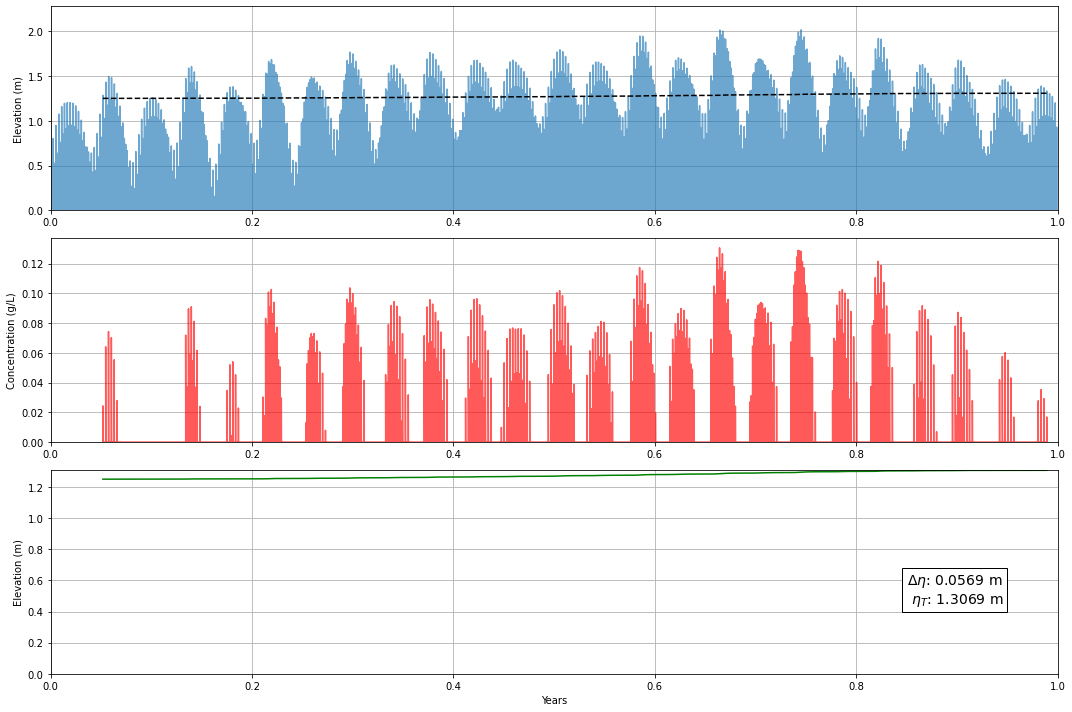

In [12]:
# define figure and axes
fig, axs = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(15)

# plot tides with elevation
axs[0].plot(h_t, h, alpha=0.65)
axs[0].plot(t, e, color="k", ls="--")
axs[0].set_ylabel("Elevation (m)")

# plot concentration
axs[1].plot(t, c, color="r", alpha=0.65)
axs[1].set_ylabel("Concentration (g/L)")

# plot elevation
axs[2].plot(t, e, color="g")
axs[2].set_ylabel("Elevation (m)")
axs[2].set_xlabel("Years")

# place text box of model results
txt = "$\Delta\eta$: {:.4f} m \n $\eta_{{T}}$: {:.4f} m".format(
    model_results.y[1][-1] - init_elev, model_results.y[1][-1]
)
axs[2].text(
    0.85,
    0.5,
    txt,
    transform=axs[2].transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(boxstyle="square", facecolor="white"),
)

# configure axes and white space
for ax in axs:
    ax.set_xlim(0, np.ceil(np.max(h_t)))
    ax.set_ylim(0)
    ax.grid()
plt.tight_layout()